In [1]:
import torch.nn.functional as Fun
import torch
import numpy as np
torch.manual_seed(100)

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

2.0.0+cpu


In [3]:
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=lambda y: torch.zeros(100, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=lambda y: torch.zeros(100, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

100%|███████████████████████████████████████████████████████████████| 169001437/169001437 [00:19<00:00, 8758240.27it/s]


Extracting data\cifar-100-python.tar.gz to data
Files already downloaded and verified


In [4]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[3] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return torch.Tensor(image_batch_updated),label


# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
for x, y in train_dataloader:
    image_batch = x
    image_batch_labels = y
    break
input_image = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch[:4], image_batch_labels[:4], 1.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch[2*i+j].numpy())
        plt.imshow(np.moveaxis(image_batch[2*i+j].numpy(),0,-1))
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)

NameError: name 'train_dataloader' is not defined

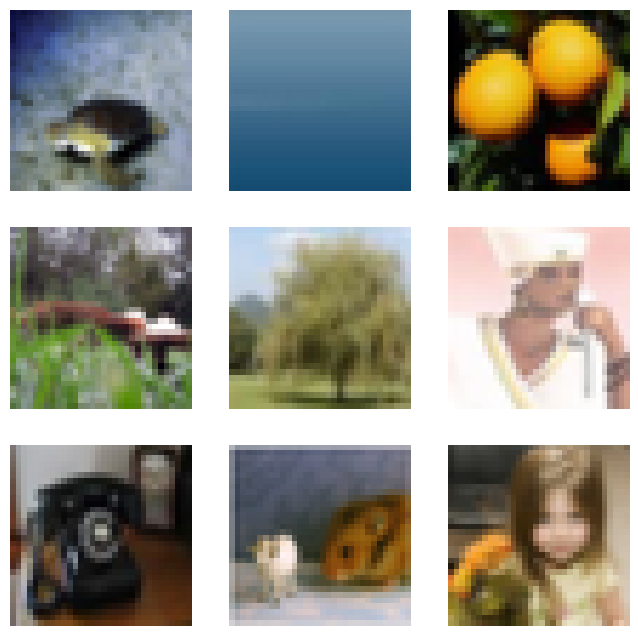

In [8]:
classes = """0: apple
1: aquarium_fish
2: baby
3: bear
4: beaver
5: bed
6: bee
7: beetle
8: bicycle
9: bottle
10: bowl
11: boy
12: bridge
13: bus
14: butterfly
15: camel
16: can
17: castle
18: caterpillar
19: cattle
20: chair
21: chimpanzee
22: clock
23: cloud
24: cockroach
25: couch
26: cra
27: crocodile
28: cup
29: dinosaur
30: dolphin
31: elephant
32: flatfish
33: forest
34: fox
35: girl
36: hamster
37: house
38: kangaroo
39: keyboard
40: lamp
41: lawn_mower
42: leopard
43: lion
44: lizard
45: lobster
46: man
47: maple_tree
48: motorcycle
49: mountain
50: mouse
51: mushroom
52: oak_tree
53: orange
54: orchid
55: otter
56: palm_tree
57: pear
58: pickup_truck
59: pine_tree
60: plain
61: plate
62: poppy
63: porcupine
64: possum
65: rabbit
66: raccoon
67: ray
68: road
69: rocket
70: rose
71: sea
72: seal
73: shark
74: shrew
75: skunk
76: skyscraper
77: snail
78: snake
79: spider
80: squirrel
81: streetcar
82: sunflower
83: sweet_pepper
84: table
85: tank
86: telephone
87: television
88: tiger
89: tractor
90: train
91: trout
92: tulip
93: turtle
94: wardrobe
95: whale
96: willow_tree
97: wolf
98: woman
99: worm"""

labels = classes.split()[1::2]
len(labels)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Случайный индекс из датасета
    img, label = training_data[sample_idx] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    #plt.title(labels[label])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(),0,-1))
plt.show()

In [9]:
img.numpy().shape

(3, 32, 32)

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [11]:
from torch import nn

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=2, padding=(2, 2), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            nn.Flatten(),
            #nn.Dropout(p=0.5),
            #nn.Linear(3, 20),
            #nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Linear(20, 100),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=2, padding=(2, 2), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            nn.Flatten(),
            #nn.Dropout(p=0.5),
            #nn.Linear(3, 20),
            #nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Linear(20, 100),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [14]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            #nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            #nn.LeakyReLU(0.1),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            #nn.Dropout(p=0.5),
            #nn.Linear(3, 20),
            #nn.ReLU(),
            #nn.LeakyReLU(0.1),
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, 100),
            nn.ReLU(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
class ActNorm(nn.Module):
    def __init__(self, a=1e-4, b=0.75, n=4, k=2):
        super().__init__()
        self.act = nn.ReLU()
        self.n = n
        self.a = a
        self.b = b
        self.k = k
    def forward(self, x):
        out = self.act(x)
        out1 = torch.ones_like(x)
        for k in range(x.shape[0]):
            for l in range(x.shape[1]):
                for i in range(x.shape[2]):
                    for j in range(x.shape[3]):
                        coef = 0
                        for i1 in range(max(0,l-int(self.n/2)), min(x.shape[1]-1,i+int(self.n/2))):
                            coef+=self.a*out[k,i1,i,j]**2
                        coef = (self.k+coef)**self.b
                        out1[k,l,i,j] = out[k,l,i,j]/coef
        
        return out1

In [16]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        #out = self.norm1(out)
        
        return x + out # self.act(x + out)

In [17]:
class BottleneckBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.act = nn.ReLU()
        
        self.conv0 = nn.Conv2d(nc, nc//4, kernel_size=1, padding=0, groups=nc//4)
        self.norm0 = nn.BatchNorm2d(nc//4)
        self.conv1 = nn.Conv2d(nc//4, nc//4, kernel_size=3, padding=1, groups=nc//4)
        self.norm1 = nn.BatchNorm2d(nc//4)
        self.conv2 = nn.Conv2d(nc//4, nc, kernel_size=1, padding=0, groups=nc//4)
        self.norm2 = nn.BatchNorm2d(nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.act(out)
        return self.act(x + out)

In [18]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks, block_type='classic'):
        super().__init__()
        
        truck = []
        for i in range(num_blocks):
            if block_type == 'classic':
                truck += [ResBlock(nc)]
            elif block_type == 'bottleneck':
                truck += [BottleneckBlock(nc)]
            else:
                raise NotImplementedError(f'{block_type} is not implemented')
        self.truck = nn.Sequential(*truck)
        
    def forward(self, x):
        return self.truck(x)

In [19]:
class RNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc):
        super(RNet, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_nc, nc, kernel_size=3, stride=1, groups=1),
            nn.BatchNorm2d(nc),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            ResTruck(nc, 1, block_type='bottleneck'),
            nn.Conv2d(nc, 2*nc, 3, padding=1, stride=1, groups=nc),
            nn.BatchNorm2d(2*nc),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            ResTruck(2*nc, 2, block_type='bottleneck'),
            nn.Conv2d(2*nc, 4*nc, 3, padding=1, stride=1, groups=2*nc),
            nn.BatchNorm2d(4*nc),
            nn.ReLU(),
            ResTruck(4*nc, 4, block_type='bottleneck'),
            nn.Conv2d(4*nc, 4*nc, 3, padding=1, stride=2, groups=4*nc),
            nn.BatchNorm2d(4*nc),
            nn.ReLU(),
            ResTruck(4*nc, 2, block_type='bottleneck'),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(4*nc*4, out_nc)
        )
    

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [20]:
class RNet2(nn.Module):
    def __init__(self, in_nc, nc, out_nc, block_type):
        super(RNet2, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_nc, nc, kernel_size=7, stride=2),
            nn.BatchNorm2d(nc),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            ResTruck(nc, 1, block_type=block_type),
            nn.Conv2d(nc, 2*nc, 3, padding=1, stride=2),
            nn.BatchNorm2d(2*nc),
            nn.ReLU(),
            ResTruck(2*nc, 2, block_type=block_type),
            nn.Conv2d(2*nc, 4*nc, 3, padding=1, stride=2),
            nn.BatchNorm2d(4*nc),
            nn.ReLU(),
            ResTruck(4*nc, 4, block_type=block_type),
            nn.Conv2d(4*nc, 4*nc, 3, padding=1, stride=2),
            nn.BatchNorm2d(4*nc),
            nn.ReLU(),
            ResTruck(4*nc, 2, block_type=block_type),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(4*nc, out_nc)
        )
    

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [22]:
class ANet(nn.Module):
    def __init__(self):
        super(ANet, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            
            nn.Conv2d(3, 48, 9, padding=4, stride=1),
            nn.MaxPool2d(3,2),
            #ActNorm(),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 96, 3, padding=1, stride=1),
            nn.MaxPool2d(3,2),
            #ActNorm(),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 144, 3, padding=1, stride=1),
            #ActNorm(),
            nn.BatchNorm2d(4*3),
            nn.ReLU(),
            nn.Conv2d(144, 144, 3, padding=1, stride=1),
            #ActNorm(),
            nn.ReLU(),
            nn.Conv2d(144, 128, 3, padding=1, stride=1),
            nn.MaxPool2d(4,3),
            #ActNorm(),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(512, 512),
            #ActNorm(),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 100),
            #ActNorm(),
            nn.ReLU(),
        )
    

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [26]:
model = NeuralNetwork2().to(device)
param_count(model)

model has 958 parameters


In [27]:
model = NeuralNetwork().to(device)
param_count(model)

model has 948 parameters


In [17]:
model = RNet(3,496,100).to(device)
param_count(model)
#50k24
#500k248
#100k48
#10k4
#1000k496

model has 993960 parameters


In [35]:
model = RNet2(3,52,100,'bottleneck').to(device)
param_count(model)

model has 676191 parameters


In [ ]:
model = ANet().to(device)

In [25]:
def param_count(model):
    c = 0
    for param in model.parameters():
        laypar = 1
        for a in list(param.size()):
            laypar *= a
      #print(f"Size: {list(param.size())}, layer: {laypar}")
        c += laypar
    print(f'model has {c} parameters')

param_count(model)

model has 958 parameters


In [18]:
loss_fn = nn.CrossEntropyLoss()

In [43]:
lf = nn.CrossEntropyLoss()
p = torch.tensor([[1.5,1.5],[1.5,1.5]])
l = torch.tensor([[0.5,0.5],[0.5,0.5]])
print(lf(p,l))

tensor(0.6931)


In [37]:
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [44]:
from tqdm import tqdm
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        X, y = generate_cutmix_image(X, y, 1.0)
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [21]:
def test_loop(dataloader, model, loss_fn, loss_list, acc_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    acc_list.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_list = []
acc_list = []

In [ ]:
loss_listm = []
acc_listm = []

In [ ]:
loss_listT = []
acc_listT = []

In [22]:
loss_listmn = []
acc_listmn = []

In [ ]:
learning_rate/=10
print(learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

1.0000000000000002e-06


In [45]:
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_listmn, acc_listmn)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\Артур\AppData\Local\Temp\ipykernel_14220\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_14220\755860063.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `n

Epoch 1
-------------------------------
loss: 3.612318  [    0/50000]
loss: 2.650053  [ 6400/50000]
loss: 3.778284  [12800/50000]
loss: 3.333629  [19200/50000]
loss: 3.068008  [25600/50000]
loss: 3.121853  [32000/50000]
loss: 3.734871  [38400/50000]
loss: 2.878340  [44800/50000]


  5%|████▏                                                                              | 1/20 [00:15<05:02, 15.94s/it]

Test Error: 
 Accuracy: 30.7%, Avg loss: 2.808287 

Epoch 2
-------------------------------
loss: 2.528758  [    0/50000]
loss: 3.988319  [ 6400/50000]
loss: 2.776266  [12800/50000]
loss: 2.946657  [19200/50000]
loss: 3.440469  [25600/50000]
loss: 3.466757  [32000/50000]
loss: 3.610534  [38400/50000]
loss: 3.377908  [44800/50000]


 10%|████████▎                                                                          | 2/20 [00:32<04:48, 16.01s/it]

Test Error: 
 Accuracy: 27.4%, Avg loss: 2.968986 

Epoch 3
-------------------------------
loss: 3.519220  [    0/50000]
loss: 3.736002  [ 6400/50000]


 10%|████████▎                                                                          | 2/20 [00:35<05:18, 17.67s/it]


KeyboardInterrupt: 

In [ ]:

print(max(acc_listmn))
plt.plot(acc_listmn)

ValueError: ignored

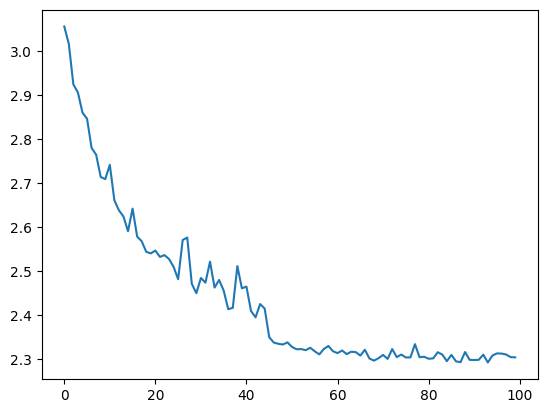

In [ ]:
plt.plot(loss_listmn[110:])

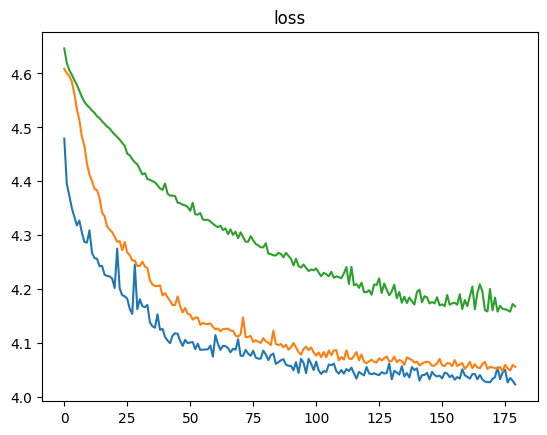

In [ ]:
plt.title('loss')
plt.plot(loss_list)
plt.plot(loss_listm)
plt.plot(loss_listT)

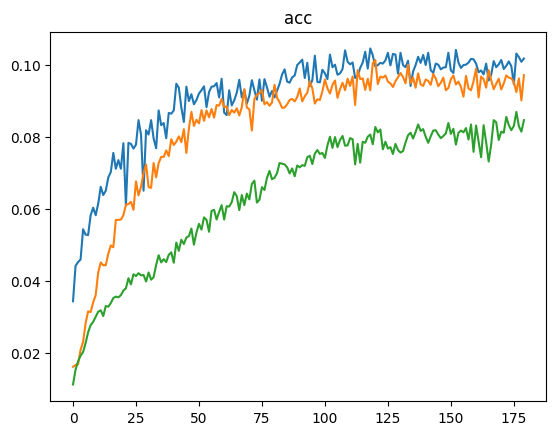

In [ ]:
plt.title('acc')
plt.plot(acc_list)
plt.plot(acc_listm)
plt.plot(acc_listT)
plt.plot(acc_listmn)